In [ ]:
# load dependencies
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path as path
import pandas as pd
from scipy.io import loadmat as loadmat

# Read Files from csv

In [71]:
# Define the current working directory
pwd = path.cwd()
print(f"Current working directory: {pwd}")

# Define the data path
data_path = pwd / "data"
ocv_data = data_path / "002_Parameterbestimmung_BOL1_OCV_GOTION1_PZE12833.mat"
data_OCV = loadmat(str(ocv_data))

Current working directory: c:\Users\wwwsp\VSCODE\RC_Model


In [72]:
print(type(data_OCV))
# Display the keys in the loaded data
print(data_OCV.keys())
data_struct = data_OCV['MeasVal']

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'MeasVal'])


In [87]:
test_time=data_struct['Test_Time']
OCV=data_struct['U_Batt_AV']
I_data = data_struct['I_Batt_AV']
step_time = data_struct['Step_Time']
SOC= data_struct['Batt_SOC_AV']
temperature = data_struct['T_Batt_AV']
capacity=data_struct['Batt_Cap_AV']

print(type(test_time))
print(type(OCV))
print(type(I_data))
print(type(step_time))

print(np.shape(test_time))
print(np.shape(OCV))
print(np.shape(I_data))
print(np.shape(step_time))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 1)
(1, 1)
(1, 1)
(1, 1)


In [74]:
 # Unwrap the nested arrays
test_time_array = test_time[0, 0]
ocv_array = OCV[0, 0]
current_array = I_data[0, 0]
step_time = step_time[0,0]
SOC=SOC[0,0]
T=temperature[0,0]
capacity = capacity[0,0]

# Flatten the arrays to 1D
test_time_flat = test_time_array.flatten() # .flatten() converts to 1D array
ocv_flat = ocv_array.flatten()
current_array_flat = current_array.flatten()
step_time_flat = step_time.flatten()
SOC_flat = SOC.flatten()
T_flat = T.flatten()
capacity_flat = capacity.flatten()

battery_capacity = capacity_flat[0]  # Assuming capacity is a single value

In [75]:
# Create a DataFrame from the data
df = pd.DataFrame({
    'Test_Time': test_time_flat,
    'OCV': ocv_flat,
    'Current': current_array_flat,
    'Step_Time': step_time_flat,
    'SOC': SOC_flat,
    'Temperature': T_flat

}) # assuming OCV has the same structure# Should be a list or array

In [76]:
df.head()  # Display the first few rows of the DataFrame

,Test_Time,OCV,Current,Step_Time,SOC,Temperature
0,0.000,3.356148,0.0,0.000,100.0,25.0
1,0.500,3.356148,0.0,0.500,100.0,25.1
2,1.000,3.356444,0.0,1.000,100.0,24.9
3,61.001,3.356148,0.0,58.964,100.0,25.0
4,121.002,3.356148,0.0,118.965,100.0,25.0


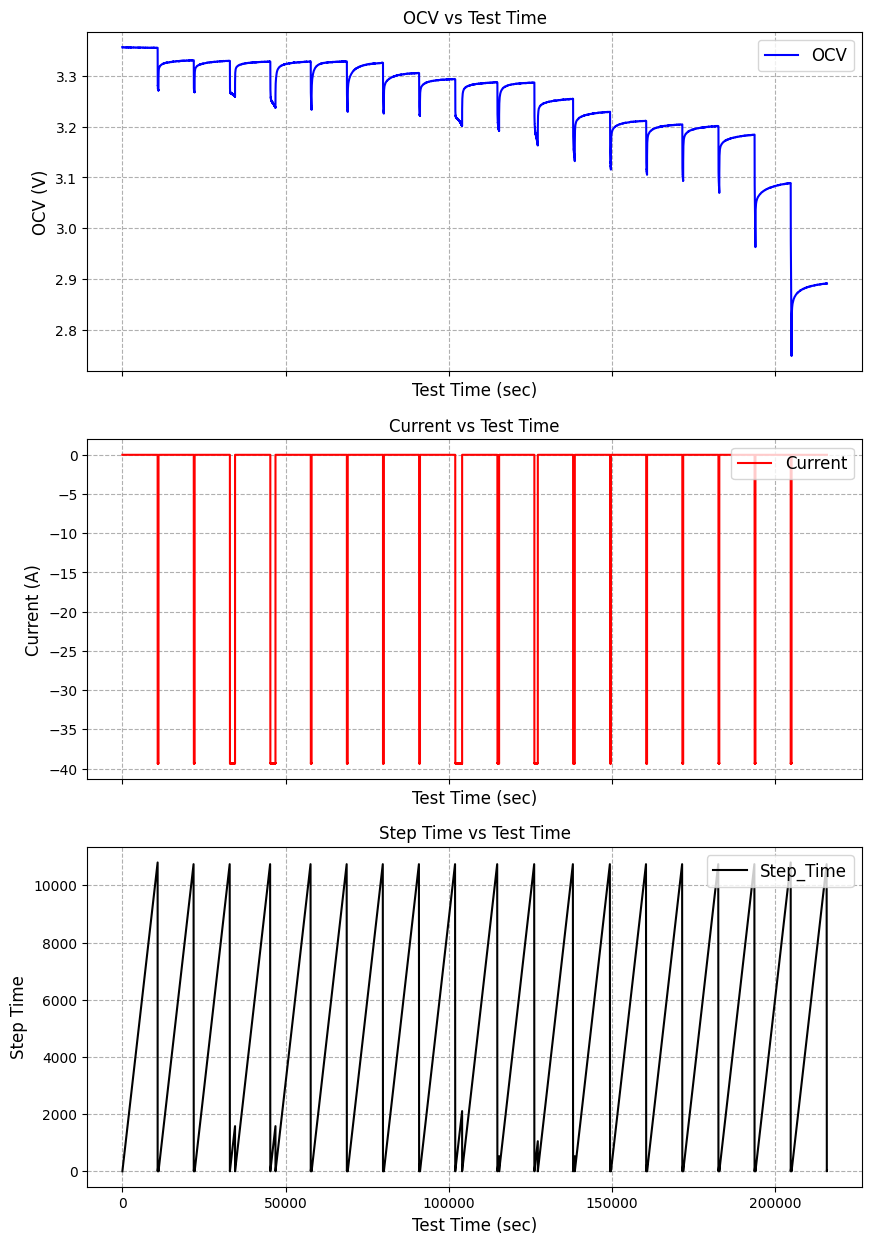

<Figure size 640x480 with 0 Axes>

In [77]:

# Plotting the data for voltage and current
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 15), dpi=100, sharex=True)  # dpi is dots per inch. For 1080p display yopically use 100 dpi or 200 dpi
ax1.plot(df['Test_Time'], df['OCV'], label='OCV', color='blue')
ax1.set_xlabel('Test Time (sec)', fontsize=12)
ax1.set_ylabel('OCV (V)',fontsize=12)
ax1.set_title('OCV vs Test Time',fontsize=12)
ax1.legend()
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, linestyle='--', alpha=1)

ax2.plot(df['Test_Time'], df['Current'], label='Current', color='red')
ax2.set_xlabel('Test Time (sec)', fontsize=12)
ax2.set_ylabel('Current (A)',fontsize=12)
ax2.set_title('Current vs Test Time',fontsize=12)
ax2.legend()
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, linestyle='--', alpha=1)

ax3.plot(df['Test_Time'], df['Step_Time'], label='Step_Time', color='black')
ax3.set_xlabel('Test Time (sec)', fontsize=12)
ax3.set_ylabel('Step Time',fontsize=12)
ax3.set_title('Step Time vs Test Time',fontsize=12)
ax3.legend()
ax3.legend(loc='upper right', fontsize=12)
ax3.grid(True, linestyle='--', alpha=1)

plt.show()
plt.tight_layout()


In [78]:
# calculate the derivative of the current with respect to time

# Method 1: Using diff()
df['dV_dt_diff'] = df['OCV'].diff() / df['Test_Time'].diff()

# Method 2: Using np.gradient()
df['dV_dt_grad'] = np.gradient(df['OCV'], df['Test_Time'])


In [79]:
position_zeros_v1 = np.where(step_time_flat == 0)[0].tolist()  # Get indices where step_time is zero. Np.where returns a tuple, we take the first element and convert it to a list
position_zeros_v2 = df[df['dV_dt_grad']== 0].index.tolist()  # Get indices where dV/dt is zerob

In [80]:
# get the time when the current is zero based on the position of zeros in the step_time_flat
pulse_time = df['Test_Time'].iloc[position_zeros_v1]
pulse_values=pulse_time.values  # Convert to numpy array for easier slicing
pulse_time_start = pulse_values[0::2]  # start times: even indices
pulse_time_end = pulse_values[1::2]    # end times: odd indices

In [82]:
pulse_time_start.shape, pulse_time_end.shape  # Check the shapes of the arrays

((18,), (17,))

In [83]:
len(position_zeros_v1)

35

In [84]:
df.head()  # Display the first few rows of the DataFrame to verify the new columns

,Test_Time,OCV,Current,Step_Time,SOC,Temperature,dV_dt_diff,dV_dt_grad
0,0.000,3.356148,0.0,0.000,100.0,25.0,NaN,0.000000
1,0.500,3.356148,0.0,0.500,100.0,25.1,0.000000,0.000296
2,1.000,3.356444,0.0,1.000,100.0,24.9,0.000593,0.000588
3,61.001,3.356148,0.0,58.964,100.0,25.0,-0.000005,-0.000002
4,121.002,3.356148,0.0,118.965,100.0,25.0,0.000000,0.000002


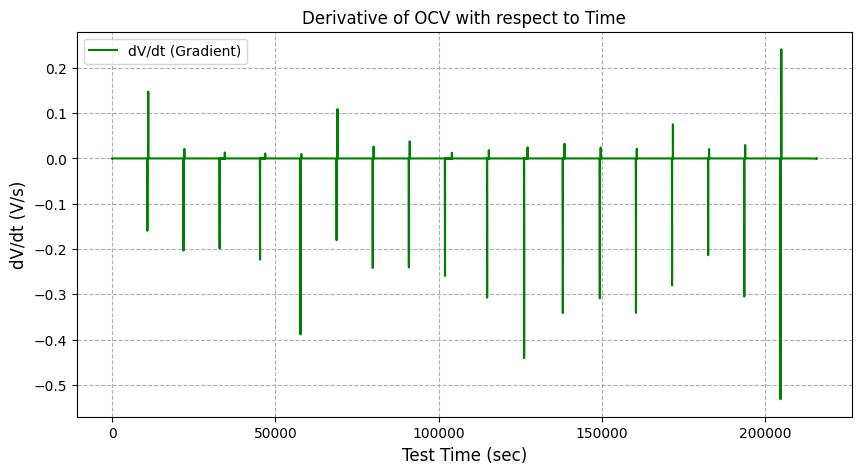

In [88]:
# Plotting the derivative of OCV with respect to time
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df['Test_Time'], df['dV_dt_grad'], label='dV/dt (Gradient)', color='green')
plt.xlabel('Test Time (sec)', fontsize=12)
plt.ylabel('dV/dt (V/s)', fontsize=12)
plt.title('Derivative of OCV with respect to Time', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=1)
plt.show()

In [102]:
# Initialize segment dictionary with list containers

segment = { # thids is a dictionary to hold the segments of data
    'voltage': [],
    'time': [],
    'duration': [],
    'soc': [],
    'temp': [],
    'crate': [],
    'current_sign': []
 # Added duration to the segment dictionary

}

for i in range(len(position_zeros_v1) - 1):
    start = position_zeros_v1[i]
    end = position_zeros_v1[i + 1]

    voltage_segment = df['OCV'].iloc[start:end].values
    time_segment = df['Test_Time'].iloc[start:end].values
    soc_segment = df['SOC'].iloc[start:end].values
    temp_segment = df['Temperature'].iloc[start:end].values
    current_segment = df['Current'].iloc[start:end].values

    # Calculate the duration of the segment
    if len(time_segment) > 0:
        duration_segment = time_segment[-1] - time_segment[0]
    else:
        duration_segment = 0

    # Fill the segment dictionary
    segment['voltage'].append(voltage_segment)
    segment['time'].append(time_segment)
    segment['duration'].append(time_segment - time_segment[0])
    segment['soc'].append(soc_segment)
    segment['temp'].append(round(np.mean(temp_segment)))
    segment['crate'].append(abs(np.mean(current_segment) / battery_capacity))

    if np.mean(current_segment) / battery_capacity < 0:
        segment['current_sign'].append(0)  # Discharge
    else:
        segment['current_sign'].append(1)  # Charge


C:\Users\wwwsp\AppData\Local\Temp\ipykernel_33416\477070456.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


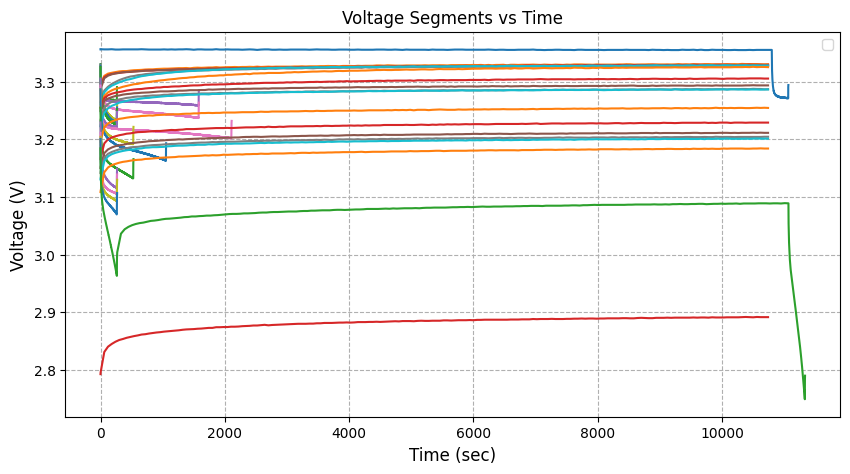

In [105]:
# Plot the segments vs their duration
plt.figure(figsize=(10, 5), dpi=100)
for i in range(len(segment['voltage'])):
    plt.plot(segment['duration'][i], segment['voltage'][i])
plt.xlabel('Time (sec)', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.title('Voltage Segments vs Time', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=1)
plt.show()